# Homework 4

## Overview

**Note**: The experiments in this project can take some time to complete. On my computer, they take more than 30 minutes to run in total (across all experiments). Please be sure to leave enough time to complete the experimental exploration.

**Also note**: Due to the environment variation (Linux/Windows/macOS/Colab), you may encounter some environment issues. Reach out to TA if necessary.

## Task 0: Setup the environment (0%)

You will complete this project using PyTorch. Install the Pytorch before you run this notebook.

You can install the package by yourself, or you can simply run the following command to install. If you run your code in Colab, it is the most convenient way

In [ ]:
! pip3 install torch torchvision --index-url https://download.pytorch.org/whl/cpu

An alternative way to install the environment is provided as follows. After running them, a Conda environment will be ready. Don't forget to activate them.

In [ ]:
# If you use CPU, uncommand the following command and run the cell
! conda env update -f environment-cpu.yml --prune
# If you use GPU, uncommand the following command and run the cell
# ! conda env update -f environment-gpu.yml --prune

Hint: Some code in this notebook will be cached dynamically. Rerun the following code every time you restart the notebook to ensure every functions work perfectly.

In [10]:
import os
os.environ["USE_LIBUV"] = "0"

In [11]:
# Reload packages automatically
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


If the code above fail, you could try the following code

In [ ]:
!pip install ipython --user

## Task 1: Distributed operations

Before start, it is suggested to check the number of processors (CPUs or GPUs). In principle, more than 1 processor is sufficient. However, it is suggested to run and test the code in the platform with more than 4 processes, which enables us to observe the benefit of distributed computing.

In [12]:
USE_GPU = False  # If you use CPU
# USE_GPU = True  # If you use GPU

if USE_GPU:
    import torch
    print("Number of GPUs: ", torch.cuda.device_count())
    backend = "nccl"
else:
    import torch.multiprocessing as mp
    backend = "gloo"

### Step 1: Distributed "Hello World"

In distributed computing, two fundamental concepts are ``world size`` and ``rank``, which provide the necessary context for managing data, synchronizing model updates, and orchestrating the entire distributed training workflow.

``World size`` refers to the total number of processes participating in a distributed computing job. This is the global count of all workers, which could be across multiple machines or multiple GPUs on a single machine.

``Rank``, on the other hand, is the unique identifier assigned to each individual process within the distributed group. Each process has a distinct rank ranging from 0 to ``World size`` - 1. This unique identifier is crucial for coordinating communication and ensuring that each process knows its specific role in the training task, such as which partition of data or which subset of a model it is responsible for.

First, we define necessary configuration.

In [13]:
import os

world_size = 4
os.environ['MASTER_ADDR'] = 'localhost'
os.environ['MASTER_PORT'] = '29501'

os.makedirs('cache', exist_ok=True)

Now we need to define a function which defines what should the each worker do.

The first step is to let each worker print its rank and your name. For example, if you are Alice, your output should be like
```bash
Rank 1: Hello, Alice!
Rank 2: Hello, Alice!
Rank 3: Hello, Alice!
Rank 4: Hello, Alice!
```

Please complete the following function.

In [14]:
%%writefile cache/H4T1S1.py
# No need to worry about this line. It's introduced to make thing go well in Jupyter notebook environment.
# ================================================

def say_hello(rank, results_queue):

    """"Step 1: Distributed ''Hello World''
    """
    # =========================================
    # Answer:
    msg = f"Rank {rank}: Hello, Cash!"
    print(msg)

    if results_queue is not None:
        results_queue.put(msg)
    # =========================================


Overwriting cache/H4T1S1.py


We will use the ``spawn`` function provided by the Python ``multiprocessing`` package as the entry. ``multiprocessing`` is a powerful tool for leveraging the full potential of modern multi-core processors. The usage of ``spawn`` is
```python
import torch.multiprocessing as mp
mp.spawn(func, args=(), nprocs=world_size, join=True)
```
where the arguments includes:

``func``: function to be performed by each process. This function should take at least one argument, the rank of the process.

``args``: A tuple of arguments to pass to the function. These arguments are shared across all processes.

``nprocs``: The number of processes to spawn. In this case, it is set to the value of ``world_size``, which is 4.

``join``: A boolean indicating whether the main process should wait for all spawned processes to finish before continuing. If set to ``True``, the main process will block until all processes have completed.


Depending on the operating system, ``print`` executed inside subprocesses may not appear in the Jupyter Notebook output. To address this, we include an additional argument, ``results_queue``, in the ``say_hello`` function. Each subprocess can place its messages into this queue, and the main process can retrieve and print them after all subprocesses have completed.


Now we run the ``say_hello`` function on each workers.

In [15]:
# No need to worry about this line. It's introduced to make thing go well in Jupyter notebook environment.
from cache.H4T1S1 import say_hello
# ================================================

import torch.multiprocessing as mp

mp.set_start_method('spawn', force=True)

results_queue = mp.Queue()

# Use spawn to create separate processes for each rank
mp.spawn(say_hello, args=(results_queue, ), nprocs=world_size, join=True)

# read results from the subprocess
for _ in range(world_size):
    # get() will block until there is message in the queue
    result = results_queue.get()
    print(result)

print("All processes finished.")

Rank 1: Hello, Cash!
Rank 3: Hello, Cash!
Rank 0: Hello, Cash!
Rank 2: Hello, Cash!
All processes finished.


### Step 2: Communication among workers


A random tensor $x_n$ is generated on each worker $n$ (already being provided). You need to implement a code that allows worker $n$ to send $x_n$ to worker $(n+1) \bmod N$, where $N$ is the world size.

Follow the hints in the function to complete the work.

In [27]:
%%writefile cache/H4T1S2.py
# No need to worry about this line. It's introduced to make thing go well in Jupyter notebook environment.
# ================================================

import torch
import torch.distributed as dist

from util import test_func_H3T1S2, generate_random_tensor

def send_message_to_next(rank, world_size, message_size, backend="gloo"):

    # =========================================================
    #   Step 0: Initialize the process group.
    # =========================================================

    # A helper function to run the example.
    dist.init_process_group(backend=backend, rank=rank, world_size=world_size)

    # prepare the tensor to send
    my_tensor = generate_random_tensor(rank, message_size)

    # =========================================================
    #   Step 1: Create a placeholder for the received tensor.
    # =========================================================
    # The receive function requires a pre-allocated tensor
    # to place the incoming data. The size must match the data sent.
    # ----------------------------------------------------------
    # Answer:
    received_tensor = torch.zeros_like(my_tensor)

    # =========================================================
    #   Step 2: Determine sender and receiver ranks.
    # =========================================================
    # The goal is for worker `n` to send to `(n+1) % N` and
    # receive from `(n-1 + N) % N`. 
    # Your goal here is to find two values: `receiver_rank` and `source_rank`.
    # receiver_rank: The rank of the worker we will send to.
    # source_rank: The rank of the worker we will receive from.
    # ----------------------------------------------------------
    # Answer:
    receiver_rank = (rank + 1) % world_size
    source_rank = (rank - 1 + world_size) % world_size


    # =========================================================
    #   Step 3: Perform the send and receive operations.
    # =========================================================

    # We use asynchronous operations to allow for simultaneous
    # communication. This is more efficient than synchronous sends/receives.
    # `dist.isend` initiates a non-blocking send.
    # `dist.irecv` initiates a non-blocking receive.
    # Your goal here is to create two request objects: `send_request` and `recv_request`.
    # ----------------------------------------------------------
    # Answer:
    send_request = dist.isend(tensor=my_tensor, dst=receiver_rank)
    recv_request = dist.irecv(tensor=received_tensor, src=source_rank)

    # =========================================================
    # Wait for the communication to complete before proceeding.
    send_request.wait()
    recv_request.wait()

    # -------------------------------------------------
    # The following function test if your received tensor is correct.
    test_func_H3T1S2(rank, world_size, message_size, received_tensor)



Overwriting cache/H4T1S2.py


(a) (5 points) Describe their difference in your own words?

send and recv are blocking meaning you cant do anything else until the runtime is done sending or receiving (and writing to the tensor) respectively. The isaend and irecv are non-blocking so they return a request object immediately, which then you call request.wait to manually apply synchronicity.

**Note**: If you do not implement the function correctly, the following code will raise an error.

In [28]:
# No need to worry about this line. It's introduced to make thing go well in Jupyter notebook environment.
from cache.H4T1S2 import send_message_to_next
# ================================================

import torch
import torch.multiprocessing as mp

message_size = torch.Size((1, 5))

# Use spawn to create separate processes for each rank
mp.spawn(send_message_to_next, args=(world_size, message_size, backend), nprocs=world_size, join=True)
print("Test passed!")


Test passed!


# Task 2: All-reduction operation

In this task, you will implement a key collective communication operation, ```all-reduce```, using only the primitive ```send``` and ```recv``` functions. Your implementation should not rely on any other collective communication functions. Let $x_n$ be a tensor on worker $n$, the result of ```all-reduce``` is that all workers have a copy of $\sum_{n=0}^{N-1} x_n$. As we will see in Task 3, ```distributed SGD``` involves ```all-reduce``` at each iteration. Therefore, ```all-reduce``` plays a critical role in the training. You will compare the efficiency of two major methods to implement ```all-reduce```.


### Step 1: Tree-all-reduce

In [43]:
%%writefile cache/H4T2S1.py

import torch
import torch.distributed as dist
import math

def reduce_to_root(data, rank, world_size):
    """
    Phase 1: Moves data up the binary tree to the root (Rank 0), performing reduction.
    """
    # =========================================================
    #   Step 1: Compute the number of iterations.
    # =========================================================

    # -------------------------------------------------
    # Answer:
    iter_num = int(math.log2(world_size))
    # -------------------------------------------------

    recv_buffer = torch.zeros_like(data)


    for i in range(iter_num):

        # =========================================================
        #   Step 2: Determine whether this node is active or not; and if active,
        #           determine whether it is parent (receiver) or child (sender).
        # =========================================================

        # Answer:
        tree_step = 2 ** i


        # =========================================================
        #   Step 3: Send message if child; Receive and reduce if parent.
        # =========================================================

        # Answer:
        if rank % (2 * tree_step) == 0:
            src = rank + tree_step
            if src < world_size:
                dist.recv(tensor=recv_buffer, src=src)
                data += recv_buffer
        
        elif rank % (2 * tree_step) == tree_step:
            dst = rank - tree_step
            dist.send(tensor=data, dst=dst)
            break
        # -------------------------------------------------


def broadcast_from_root(data, rank, world_size):
    """
    Phase 2: Moves the final reduced result down the binary tree from the root (Rank 0).
    """

    # =========================================================
    #   Step 1: Compute the number of iterations.
    # =========================================================

    # -------------------------------------------------
    # Answer:
    iter_num = int(math.log2(world_size))
    # -------------------------------------------------

    # =========================================================
    #   Step 2: Main loop for reduction.
    # =========================================================
    for i in range(iter_num -1, -1, -1):

        # =========================================================
        #   Step 3: Determine the role
        # =========================================================
        # Answer:
        tree_step = 2 ** i


        # =========================================================
        #   Step 4: Send message if parent; Receive if children.
        # =========================================================
        # Answer:

        if rank % (2 * tree_step) == 0:
            dst = rank + tree_step

            if dst < world_size:
                dist.send(tensor=data, dst=dst)

        elif rank % (2 * tree_step) == tree_step:
            src = rank - tree_step
            dist.recv(tensor=data, src=src)
        
        # -------------------------------------------------

    
def tree_all_reduce(local_data):
    """
    Implements the TreeAllReduce algorithm using torch.distributed primitives.
    """
    rank = dist.get_rank()
    world_size = dist.get_world_size()

    if world_size == 1:
        return local_data

    
    # =========================================================
    # --- Phase 1: Reduce-to-Root ---
    # =========================================================
    # Answer:
    reduce_to_root(local_data, rank, world_size)
    # =========================================================
    # --- Phase 2: Broadcast-from-Root ---
    # =========================================================
    # Answer:
    broadcast_from_root(local_data, rank, world_size)
    # -------------------------------------------------

    return local_data

Overwriting cache/H4T2S1.py


(a) (5 points) For N workers, how many total communication steps (both phases) are required to complete Tree-all-reduce? 
2 * log2N

(b) (5 points) At the i-th step of Phase I, which ranks send data, and which ranks receive it? Specify their counts and rank indices. 

receive where: rank % 2^i+1=0
send where: rank % 2^i+1=2^i

num receivers = N / (2^(i+1)) - 1
num senders = N / (2^(i+1)) - 1

(c) (5 points) At the i-th step of Phase I, worker n sends data to worker n′. Express n′ as a function of i, n, and N.

n' = (n-2^i + N) % N


#### The following code test your implementation.

In [44]:
# No need to worry about this line. It's introduced to make thing go well in Jupyter notebook environment.
from cache.H4T2S1 import tree_all_reduce
# ================================================

import torch.multiprocessing as mp

from util import run_all_reduce

message_size = torch.Size((4,))
# Use spawn to create separate processes for each rank
mp.spawn(run_all_reduce, args=(tree_all_reduce, world_size, message_size, backend), nprocs=world_size, join=True)
print("Test passed!")

Test passed!


## Step 2: Ring-All-Reduce

In [60]:
%%writefile cache/H4T2S2.py


import torch.multiprocessing as mp

import torch
import torch.distributed as dist

from util import test_func_H3T1S2, generate_random_tensor

def ring_all_reduce(local_data):
    """
    Implements the RingAllReduce algorithm using torch.distributed.isend and recv
    with correct indexing for both phases.
    """

    # =========================================================
    #   Step 0: Initialization.
    # =========================================================
    rank = dist.get_rank()
    world_size = dist.get_world_size()

    if world_size == 1:
        return local_data

    # A temporary tensor to store the received data
    recv_tensor = torch.zeros_like(local_data)

    # Divide the data into chunks
    chunks = list(torch.chunk(local_data, world_size))


    # =========================================================
    #   Step 1: Calculate the neighbors.
    # =========================================================
    # Answer:
    prev_rank = (rank - 1 + world_size) % world_size
    next_rank = (rank + 1) % world_size

    # =========================================================
    #   Step 2: Scatter-reduce.
    # =========================================================

    for i in range(world_size - 1):
        # Answer:
        send_idx = (rank - i) % world_size
        recv_idx = (rank - i - 1) % world_size

        recv_tensor = torch.zeros_like(chunks[recv_idx])

        send_req = dist.isend(tensor=chunks[send_idx], dst=next_rank)
        dist.recv(tensor=recv_tensor, src=prev_rank)
        send_req.wait()

        chunks[recv_idx] += recv_tensor
    # =========================================================
    #   Step 3: All-Gather
    # =========================================================

    for i in range(world_size - 1):
        # Answer:
        send_idx = (rank - i + 1) % world_size
        recv_idx = (rank - i) % world_size

        send_req = dist.isend(tensor=chunks[send_idx], dst=next_rank)
        dist.recv(tensor=chunks[recv_idx], src=prev_rank)
        send_req.wait()
        
    #---------------------------------------------------------
        
    # Reconstruct the final tensor from the chunks
    final_tensor = torch.cat(chunks, dim=0)

    return final_tensor



Overwriting cache/H4T2S2.py


(a) (5 points) At the i-th step in Phase I, which chunk index c does worker n send to its left neighbor?
Express c as a function of i and n.

c = (n-i) % N

#### The following code test your implementation. 

In [61]:
# No need to worry about this line. It's introduced to make thing go well in Jupyter notebook environment.
from cache.H4T2S2 import ring_all_reduce
# ================================================

import torch.multiprocessing as mp

from util import run_all_reduce

message_size = torch.Size((4,))
# Use spawn to create separate processes for each rank
mp.spawn(run_all_reduce, args=(ring_all_reduce, world_size, message_size, backend), nprocs=world_size, join=True)
print("Test passed!")

Test passed!


(a) (2 points) How much time does it take to send data of size D from one worker to another?

t + (D/b)


(b) (2 points) How much time does it take to complete a Ring-all-reduce?

2(N-1)(t + D/(Nb))


(c) (2 points) How much time does it take to complete a Tree-all-reduce?

2log2N(t + (D/b))


(d) (4 points) Discuss when Ring-all-reduce is preferred and when Tree-all-reduce is preferred, in terms of t, b, D, and N.

All-reduce preferred when D is big: D/b >> t
Tree all-reduce is preferred when D is small: t >> D/b

# Task 3: Distributed training

## Step 1: Stochastic gradient descent in single machine

In [64]:
import os
import torch.nn as nn

# --- Define the Simple MLP Model (2 Layers) ---
class SimpleMLP(nn.Module):
    """
    Two-layer Multi-Layer Perceptron for MNIST (1x28x28 input).
    Input size: 28*28 = 784
    """
    def __init__(self):
        super(SimpleMLP, self).__init__()
        input_size = 28 * 28
        hidden_size = 256 # Example hidden size

        # First fully connected layer (Input 784 -> Hidden 256)
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        # Second fully connected layer (Hidden 256 -> Output 10 classes)
        self.fc2 = nn.Linear(hidden_size, 10)

    def forward(self, x):
        # Flatten the 1x28x28 image into a 784 vector
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


In [75]:
%%writefile cache/H4T2S1.py


import torch

import torch.nn as nn
import torch.optim as optim
from torch.utils.data.distributed import DistributedSampler
from torch.utils.data import DataLoader

# --- hyperparameters ---
# TODO: choose appropriate hyperparameters
BATCH_SIZE = 64
LEARNING_RATE = 0.1
EPOCHS = 5
# -----------------------

def main_single_machine(model, train_dataset, test_model_func, device):
    """
    Simple single-machine SGD training demonstration.

    This function performs a standard synchronous mini-batch SGD training loop
    on a single process (no distributed communication). It is meant as an
    input demonstration showing how to use the provided arguments.

    Args
    ----
    model : torch.nn.Module
        The model to train.
    train_dataset : torch.utils.data.Dataset
        Dataset providing training samples.
    test_dataset : torch.utils.data.Dataset
        Dataset providing test samples.
    device : torch.device
        Device to run training on (cpu or cuda).

    Returns
    -------
    A tuple of (model, loss_hist, theta_hist) where
      'model' : The trained model.
      'loss_hist' : (EPOCHS+1,) training loss over epochs
      'acc_hist' : (EPOCHS+1,) test accuracy over epochs
    """

    # Train Loader with DistributedSampler
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False
    )

    # Optimizer, Loss
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()

    loss_hist, acc_hist = [], []

    # Training Loop
    for epoch in range(1, EPOCHS + 1):
        total_loss = 0.0

        for batch_idx, (data, target) in enumerate(train_loader):

            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()

            # =========================================
            #  Step 1: Forward pass and calculate loss
            # =========================================
            # Answer:
            outputs = model(data)
            loss = criterion(outputs, target)

            # =========================================
            #  Step 2: Backward pass (calculate local gradients)
            # =========================================
            # Answer:
            loss.backward()
            # =========================================
            #  Step 3: Update weights using local gradients
            # =========================================
            # Answer:
            optimizer.step()


            # =========================================
            total_loss += loss.item()
        # Record average loss
        avg_loss = total_loss / len(train_loader)
        loss_hist.append(avg_loss)

        acc = test_model_func(model, device)
        acc_hist.append(acc)
        print(f'Epoch {epoch}: Average Loss: {total_loss / len(train_loader):.4f}, Test Accuracy: {acc:.2f}%')

    return model, loss_hist, acc_hist

Overwriting cache/H4T2S1.py


In [76]:
from cache.H4T2S1 import main_single_machine

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

# Load Data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)

# --- Test Function ---
def test_model_func(model, device):
    """Evaluates the model on the test dataset."""
    # Test Loader (only need one for rank 0)
    test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

    model.eval() # Set model to evaluation mode
    test_loss = 0
    correct = 0
    with torch.no_grad(): # Disable gradient calculations during evaluation
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # Sum up batch loss
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            # Get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    accuracy = 100. * correct / len(test_loader.dataset)

    return accuracy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleMLP().to(device)
main_single_machine(model, train_dataset, test_model_func, device)


Epoch 1: Average Loss: 0.2461, Test Accuracy: 95.87%
Epoch 2: Average Loss: 0.1033, Test Accuracy: 97.02%
Epoch 3: Average Loss: 0.0695, Test Accuracy: 97.41%
Epoch 4: Average Loss: 0.0508, Test Accuracy: 97.68%
Epoch 5: Average Loss: 0.0385, Test Accuracy: 97.81%


(SimpleMLP(
   (fc1): Linear(in_features=784, out_features=256, bias=True)
   (relu): ReLU()
   (fc2): Linear(in_features=256, out_features=10, bias=True)
 ),
 [0.246080724622256,
  0.10329096681892133,
  0.06954403897945477,
  0.05082728655934125,
  0.03850261026510357],
 [95.87, 97.02, 97.41, 97.68, 97.81])

Epoch 1: Average Loss: 0.0038, Test Accuracy: 98.06%
Epoch 2: Average Loss: 0.0033, Test Accuracy: 98.11%
Epoch 3: Average Loss: 0.0029, Test Accuracy: 98.15%
Epoch 4: Average Loss: 0.0026, Test Accuracy: 98.18%
Epoch 5: Average Loss: 0.0024, Test Accuracy: 98.20%


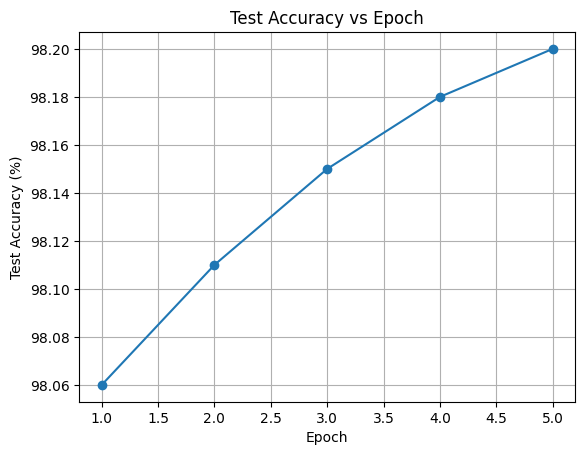

In [81]:
trained_model, loss_hist, acc_hist = main_single_machine(model, train_dataset, test_model_func, device)

import matplotlib.pyplot as plt

EPOCHS = 5
epochs = range(1, EPOCHS + 1)

plt.figure()
plt.plot(epochs, acc_hist, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy (%)")
plt.title("Test Accuracy vs Epoch")
plt.grid(True)
plt.show()


## Step 2: Parallel SGD

In [77]:
%%writefile cache/H4T2S2.py

import os
import torch

import torch.nn.functional as F
import torch.optim as optim
import torch.distributed as dist
from torch.utils.data.distributed import DistributedSampler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn as nn
# =======================================
# --- Configuration ---
# =======================================
# choose appropriate hyperparameters

BATCH_SIZE = 64
LEARNING_RATE = 0.1
EPOCHS = 5

# --- 1. Define the Simple MLP Model (2 Layers) ---
class SimpleMLP(nn.Module):
    """
    Two-layer Multi-Layer Perceptron for MNIST (1x28x28 input).
    Input size: 28*28 = 784
    """
    def __init__(self):
        super(SimpleMLP, self).__init__()
        input_size = 28 * 28
        hidden_size = 256 # Example hidden size

        # First fully connected layer (Input 784 -> Hidden 256)
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        # Second fully connected layer (Hidden 256 -> Output 10 classes)
        self.fc2 = nn.Linear(hidden_size, 10)

    def forward(self, x):
        # Flatten the 1x28x28 image into a 784 vector
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# --- 2. Setup and Cleanup Functions for Distributed Processes ---
def setup(rank, world_size):
    """Initialize the distributed environment."""
    os.environ['MASTER_ADDR'] = 'localhost'
    os.environ['MASTER_PORT'] = '12355' # Use a random free port
    # Initialize the process group
    dist.init_process_group("gloo", rank=rank, world_size=world_size)
    print(f"Process {rank} successfully initialized using 'gloo' backend.")

def cleanup():
    """Destroy the process group."""
    dist.destroy_process_group()

# --- Test Function ---
def test_model(model, device, test_loader):
    """Evaluates the model on the test dataset."""
    model.eval() # Set model to evaluation mode
    test_loss = 0
    correct = 0
    with torch.no_grad(): # Disable gradient calculations during evaluation
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # Sum up batch loss
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            # Get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    accuracy = 100. * correct / len(test_loader.dataset)
    test_error = 100. - accuracy

    print(f'\n======================================================')
    print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)')
    print(f'Final Test Error: {test_error:.2f}%')
    print(f'======================================================\n')

    return test_loss, accuracy

# --- Training Worker Function (Target for mp.spawn) ---
def run_worker(rank, world_size, result):
    """
    Main function executed by each spawned process.
    It sets up DDP, loads data, trains the model, and performs model aggregation manually.

    'result' is a dictionary to store test results per epoch for rank 0 process.
    """
    print(f"Starting training on rank {rank}.")

    # 4.1 Initialize Distributed Process Group
    setup(rank, world_size)
    device = torch.device("cpu") # For this simple example, we stick to CPU with gloo

    # 4.2 Load Data (using DistributedSampler for Train, standard DataLoader for Test)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)

    # Train Loader with DistributedSampler
    train_sampler = DistributedSampler(train_dataset, num_replicas=world_size, rank=rank, shuffle=True)
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        sampler=train_sampler,
        shuffle=False
    )

    # Test Loader (only need one for rank 0)
    test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)


    # 4.3 Model, Optimizer, Loss
    model = SimpleMLP().to(device)
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()

    # 4.4 Training Loop
    for epoch in range(1, EPOCHS + 1):
        # Set sampler epoch to ensure proper shuffling across epochs
        train_sampler.set_epoch(epoch)
        total_loss = 0.0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()

            # =========================================
            #  Step 1: Forward pass and calculate loss
            # =========================================
            # Answer:
            outputs = model(data)
            loss = criterion(outputs, target)

            # =========================================
            #  Step 2: Backward pass (calculate local gradients)
            # =========================================
            # Answer:
            loss.backward()
            # =========================================
            #  Step 3: Update weights using local gradients
            # =========================================
            # Answer:
            optimizer.step()
            # =========================================
            #  Step 4: Model Aggregation (Manual All-Reduce)
            # =========================================
            

            for param in model.parameters():
                # Your goal here is to:
                # 1. Sum the parameters (param.data) across all processes.
                # 2. Divide by the world size to get the average model parameter.
                # Answer:
                dist.all_reduce(param.data, op=dist.ReduceOp.SUM)
                param.data /= world_size


            total_loss += loss.item()
            # =========================================

        if rank == 0:
            avg_loss = total_loss / len(train_loader)
            print(f"--- Rank {rank} finished Epoch {epoch}. Average Train Loss: {avg_loss:.4f} ---")
            ## Record test results per epoch
            test_loss, test_acc = test_model(model, device, test_loader)
            result[epoch] = [test_loss, test_acc]


    # 4.6 Cleanup
    if rank == 0:
        print("Training and Evaluation complete. Cleaning up distributed environment...")
    cleanup()

Overwriting cache/H4T2S2.py


In [82]:
from cache.H4T2S2 import run_worker

import torch.multiprocessing as mp

WORLD_SIZE = 4
## Similar to Task 1, we create a special manager dict to store results from different processes
## We will pass this to each process so they can write their results
manager = mp.Manager()
result = manager.dict()

# --- Main Execution Block ---
mp.spawn(
    run_worker,
    args=(WORLD_SIZE, result), # Arguments passed to run_worker: (rank, world_size)
    nprocs=WORLD_SIZE, # Number of processes to spawn
    join=True
)

## print the results
for epoch, (test_loss, test_acc) in dict(result).items():
    print(f"Epoch {epoch}: Average Loss = {test_loss:.4f}, Test Accuracy = {test_acc:.2f}%")


Epoch 1: Average Loss = 0.2570, Test Accuracy = 92.49%
Epoch 2: Average Loss = 0.2006, Test Accuracy = 94.01%
Epoch 3: Average Loss = 0.1597, Test Accuracy = 95.32%
Epoch 4: Average Loss = 0.1294, Test Accuracy = 96.11%
Epoch 5: Average Loss = 0.1153, Test Accuracy = 96.59%


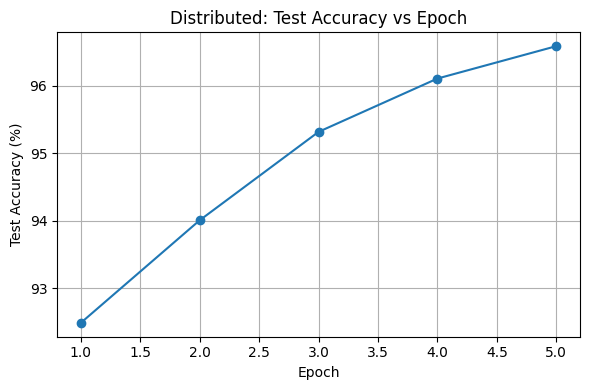

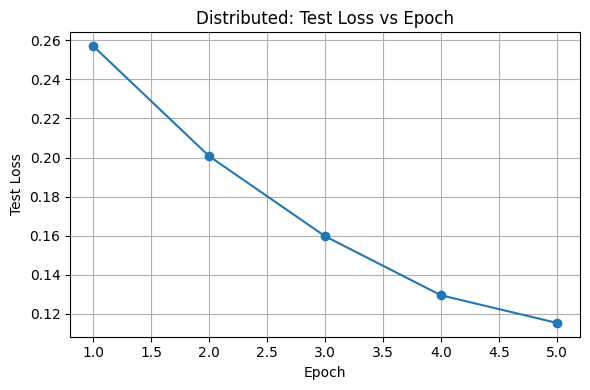

In [83]:
import matplotlib.pyplot as plt

res = dict(result)
epochs = sorted(res.keys())
loss_hist = [res[e][0] for e in epochs]
acc_hist  = [res[e][1] for e in epochs]

plt.figure(figsize=(6,4))
plt.plot(epochs, acc_hist, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy (%)")
plt.title("Distributed: Test Accuracy vs Epoch")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(epochs, loss_hist, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Test Loss")
plt.title("Distributed: Test Loss vs Epoch")
plt.grid(True)
plt.tight_layout()
plt.show()


(a) (10 points) Let k∗(N) be the iterations that Parallel SGD with N workers reaches the 85% accuracy
on test set. Set the world-size as 1, 2, 3, 4, and run Parallel SGD. Compute the speedup.



(b) (5 points) Ideally, a well-scalable distributed system enables the speedup to increase linearly as more
devices are deployed, i.e., k∗(1)/k∗(N) = N. Does Parallel SGD achieve linear speedup? If not, speculate what the bottleneck is.

No, Parallel SGD generally does not achieve linear speedup. The bottlenecks are likely: parameter averaging every iteration, synchronization, and as N grows, computation per worker per step shrinks but communication doesn’t shrink proportionally.


# Submission Instructions

After you ensure all the codes you implement work faithfully as you want, run the following code. It will help you generate a ``hw_functions.py`` file that is ready for submission. Please submit ``hw_functions.py`` onto Canvas.

In [ ]:
from util import combine_cache_functions

# Example usage (run this cell to create hw4_functions.py)
combine_cache_functions(cache_dir="cache", out_file="hw4_functions.py")

Created 'hw4_functions.py' with 10 unique imports and 8 definitions.


: 